# Using a Gradient Boosted Tree to Predict Net Loss

# 1. Import Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill
import random

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import warnings

from patsy import dmatrices, dmatrix, build_design_matrices

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If this script is used on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If this script is used locally, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

# 2. Load the Data 

There are two pre-built data sets. 
The first is a 2% random sample of the full data set (split into training and testing), and it is about 397,000 rows in each of the training and testing set (or almost 800,000 rows total). 
The full data set is about 40,000,000 rows with 90% of the data being training and the other 10% for testing. The full data set can be loaded by setting the variable:`full_data_set` to `True`.


Variable `p` allows you to choose how much of the training set to load in

The dependent variable `NET_LOSS` is in both the training and testing. The self-evaluated RMSE will be the evaluation criteria.

In [3]:
%%time

full_data_set = True

if not full_data_set:
    df_train = pd.read_csv('~/Fannie Mae Data/FannieMaeNetLossSmallTrain.csv', sep='|')
    df_test = pd.read_csv('~/Fannie Mae Data/FannieMaeNetLossSmallTest.csv', sep='|')

if full_data_set:
    # This p is the proportion of the training data loaded.
    p = .05
    random.seed(201)
    df_train = pd.read_csv('~/Fannie Mae Data/FannieMaeNetLossTrain.csv',
                           sep='|',
                           skiprows=lambda i: i>0 and random.random() > p)
    df_test = pd.read_csv('~/Fannie Mae Data/FannieMaeNetLossTest.csv', sep='|')

Wall time: 48.9 s


In [4]:
df_train.shape

(1601444, 32)

In [5]:
df_test.shape

(3977372, 32)

# 3. Summarize the Data

This section summarizes the data, sees what missing values look like, and distinguishes between continuous and categorical variables. Just because a variable is a number (i.e. `int64` for integers or `float64` for real numbers) doesn't mean it's continuous. For example, `NUMBER_OF_BORROWERS` has 8 unique values. Those values are all numbers, so it is a `float64` variable, but that variable really is the number of borrowers on the loan, which is better thought of as a categorical variable. The data glossary from the [Fannie Mae website](https://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html) (direct link to glossary is [here](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf)) gives further explanation into what each variable means.

The data set contains all of the variables from the acquisition file, and additional pre-computed variables that are not in the glossary:
  * `CREDIT_SCORE_MIN`: The minimum of the borrower and the co-borrowers credit score.
  * `ORIGINAL_VALUE`: The original value of the house. Computed from `ORIGINAL_LTV` (original loan to value) and `ORIGINAL_UPB` (original unpaid balance).
  * `YEAR`: The year that the loan was originated.
  
`NET_LOSS` (the dependent variable) was computed using data from the performance file.

In [6]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

In [7]:
summarize_dataframe(df_train)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,,,,
LOAN_IDENTIFIER,int64,0,1601444,1601444.0,,,,5.50024e+11,2.59925e+11,1.00001e+11,3.2488e+11,5.50041e+11,7.75366e+11,1e+12
ORIGINATION_CHANNEL,object,0,3,1601444.0,3,R,806443,,,,,,,
SELLER_NAME,object,0,95,1601444.0,95,OTHER,544220,,,,,,,
ORIGINAL_INTEREST_RATE,float64,0,2762,1601444.0,,,,5.23814,1.29102,1.875,4.25,5.25,6.125,12.63
ORIGINAL_UPB,float64,0,857,1601444.0,,,,189429,109200,5000,108000,164000,248000,1.223e+06
ORIGINAL_LOAN_TERM,int64,0,254,1601444.0,,,,307.171,82.2833,60,240,360,360,360
ORIGINATION_DATE,object,0,234,1601444.0,234,2003-07-01,25987,,,,,,,
FIRST_PAYMENT_DATE,object,0,235,1601444.0,235,2003-09-01,25772,,,,,,,
ORIGINAL_LTV,float64,0,97,1601444.0,,,,70.0444,17.4699,1,60,75,80,97


In [8]:
summarize_dataframe(df_test)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,,,,
LOAN_IDENTIFIER,int64,0,3977372,3977372.0,,,,5.49819e+11,2.59703e+11,1.00001e+11,3.24944e+11,5.49787e+11,7.74691e+11,1e+12
ORIGINATION_CHANNEL,object,0,3,3977372.0,3,R,2000462,,,,,,,
SELLER_NAME,object,0,95,3977372.0,95,OTHER,1351229,,,,,,,
ORIGINAL_INTEREST_RATE,float64,0,3539,3977372.0,,,,5.23789,1.28981,2,4.25,5.25,6.125,12.99
ORIGINAL_UPB,float64,0,922,3977372.0,,,,189463,109179,4000,108000,165000,248000,1.403e+06
ORIGINAL_LOAN_TERM,int64,0,283,3977372.0,,,,307.127,82.3371,60,240,360,360,360
ORIGINATION_DATE,object,0,234,3977372.0,234,2003-07-01,64770,,,,,,,
FIRST_PAYMENT_DATE,object,0,235,3977372.0,235,2003-09-01,64154,,,,,,,
ORIGINAL_LTV,float64,0,97,3977372.0,,,,70.0514,17.4542,1,60,75,80,97


Given the size of the dataset, it is infeasible to submit predictions, so performance will only be evaluated directly on the test set. Good reminder to avoid overfitting the test set.

# 4. Engineer Row Based Features

This converts `ORIGINATION_DATE` and `FIRST_PAYMENT_DATE` columns from an object (i.e., string) to a formal datetime object in Python.

In [9]:
df_train['ORIGINATION_DATE'] = pd.to_datetime(df_train['ORIGINATION_DATE'], format='%Y-%m-%d')
df_train['FIRST_PAYMENT_DATE'] = pd.to_datetime(df_train['FIRST_PAYMENT_DATE'], format='%Y-%m-%d')

df_test['ORIGINATION_DATE'] = pd.to_datetime(df_test['ORIGINATION_DATE'], format='%Y-%m-%d')
df_test['FIRST_PAYMENT_DATE'] = pd.to_datetime(df_test['FIRST_PAYMENT_DATE'], format='%Y-%m-%d')

# 5. Split Into Training and Validation

As is best practice, this splits the training dataset into a smaller training and validation set.

In [10]:
df_train['MONTHLY_PAYMENT']=df_train['ORIGINAL_UPB']*(((df_train['ORIGINAL_INTEREST_RATE']/100)/12)*(1+((df_train['ORIGINAL_INTEREST_RATE']/100)/12))**df_train['ORIGINAL_LOAN_TERM'])/((1+((df_train['ORIGINAL_INTEREST_RATE']/100)/12))**(df_train['ORIGINAL_LOAN_TERM']-1))

In [11]:
df_test['MONTHLY_PAYMENT']=df_test['ORIGINAL_UPB']*(((df_test['ORIGINAL_INTEREST_RATE']/100)/12)*(1+((df_test['ORIGINAL_INTEREST_RATE']/100)/12))**df_test['ORIGINAL_LOAN_TERM'])/((1+((df_test['ORIGINAL_INTEREST_RATE']/100)/12))**(df_test['ORIGINAL_LOAN_TERM']-1))

In [12]:
summarize_dataframe(df_test)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,,,,,,
LOAN_IDENTIFIER,int64,0,3977372,3977372.0,,,,,,5.49819e+11,2.59703e+11,1.00001e+11,3.24944e+11,5.49787e+11,7.74691e+11,1e+12
ORIGINATION_CHANNEL,object,0,3,3977372.0,3,R,2000462,,,,,,,,,
SELLER_NAME,object,0,95,3977372.0,95,OTHER,1351229,,,,,,,,,
ORIGINAL_INTEREST_RATE,float64,0,3539,3977372.0,,,,,,5.23789,1.28981,2,4.25,5.25,6.125,12.99
ORIGINAL_UPB,float64,0,922,3977372.0,,,,,,189463,109179,4000,108000,165000,248000,1.403e+06
ORIGINAL_LOAN_TERM,int64,0,283,3977372.0,,,,,,307.127,82.3371,60,240,360,360,360
ORIGINATION_DATE,datetime64[ns],0,234,3977372.0,234,2003-07-01 00:00:00,64770,1999-01-01 00:00:00,2018-06-01 00:00:00,,,,,,,
FIRST_PAYMENT_DATE,datetime64[ns],0,235,3977372.0,235,2003-09-01 00:00:00,64154,1999-02-01 00:00:00,2018-08-01 00:00:00,,,,,,,
ORIGINAL_LTV,float64,0,97,3977372.0,,,,,,70.0514,17.4542,1,60,75,80,97


In [13]:
df_smaller_train, df_validation = train_test_split(df_train, test_size = 0.25, random_state = 201)

In [14]:
#There is a bug that gives a warning later on in the code which can be fixed by making copies of the above dataframe.
df_smaller_train = df_smaller_train.copy()
df_validation = df_validation.copy()

# 5.  Impute
## 5.1 Create Imputer Transformer

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
#The imputing transformer below lumps missing values for categorical variables into an "OTHER" category. Any missing values that make up less than 10% of the overall dataset will be lumped into an "OTHER" category.
#Other imputing techniques below including replacing the missing values with the most common value in a category.
class CategoricalImputer(BaseEstimator, TransformerMixin):
    """
    
    Custom defined imputer for categorical data. This specifies an OTHER class 
    
    """
    
    def __init__(self, other_threshold=0, 
                 other_label="OTHER",
                 missing_first=True,
                 missing_values=np.nan, 
                 strategy='constant', 
                 fill_value="MISSING", 
                 verbose=0, 
                 copy=True, 
                 add_indicator=False):
        self._other_threshold = other_threshold
        self._other_label = other_label
        self._missing_first = missing_first
        if hasattr(missing_values, "__iter__"):
            self._missing_values = missing_values
        else:
            self._missing_values = [missing_values]
        self._imputer = SimpleImputer(missing_values=missing_values, strategy=strategy, fill_value=fill_value, verbose=verbose, copy=copy, add_indicator=add_indicator)
        self._column_categories = {}
        
    def fit(self, X, y=None):
        if type(self._other_threshold) == int or type(self._other_threshold) == float:
            other_threshold = [self._other_threshold]*len(X.columns)
        elif len(self._other_threshold) == len(X.columns):
            other_threshold = self._other_threshold
        else:
            raise TypeError("other_threshold must be either a single number or a list of numbers equal to the number of columns.")

        i = 0
        X = X.copy()
        X = X[:].astype(object)
        if self._missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        column_categories = {}
        for column in X.columns:
            if other_threshold[i] < 1:
                other_threshold[i] = other_threshold[i]*X[column].shape[0]
            
            value_counts = X[column].value_counts()
            categories = [category for category in value_counts.index if value_counts.loc[category] >= other_threshold[i]]
            if value_counts.iloc[-1] >= other_threshold[i]:
                categories[-1] = self._other_label
            else:
                categories.append(self._other_label)
            
            self._column_categories[column] = categories
            i = i + 1
        
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X = X[:].astype(object)
        if self._missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        for column in X.columns:
            X.loc[~X[column].isin(self._column_categories[column]) & ~X[column].isin(self._missing_values), column] = self._other_label
        return pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)[:].astype(str)

`CategoricalImputer` example:

```python
imputer=CategoricalImputer()
imputer.fit(X[["Categorical Column 1", "Categorical Column 2"]])
imputer.transform(X[["Categorical Column 1", "Categorical Column 2"]])
```

Categorical Imputer will just replace all missing values (`np.nan`) with the word "MISSING". Additionally:
  * `other_threshold`: This will set the threshold for which if there are any categories below the threshold, it will replace them with the word "OTHER. Numbers betwen 0 and 1 will be interpreted as a fraction of the full data (.1 will mean that the category has to make up at least 10% of the data to be included, otherwise it becomes "OTHER"). Integers will indicate the absolute number of rows that have to have that category (e.g. 1000 means that 1000 rows have to have that category or it gets grouped with "OTHER"). Lists will indicate the columns for the threshold. The threshold for the column will correspond to the threshold in the same place in the list. **By default this is `0`.**
  * `other_label`: This sets the label for the other category. **By default this is `"OTHER"`.**
  * `missing_first`: If this is `True`, then missing values are imputed first and then the missing category is treated like any other category. This means that if the number of missing observations is below the threshold, it will be lumped into "OTHER". If this is `False`, then missing values will be imputed at the end.

All imputer values can be set just like the `SimpleImputer` function where the documentation is [here](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). Defaults are: 

`missing_values = np.nan` 

`strategy =  'constant' ` or `strategy = 'most_frequent'` if it's better to use the most frequent category as a fill

`fill_value = "MISSING"` 

This imputer will also set the least common class the value of `other_label` (by default "OTHER"). This allows any values that are in the test data, but not the training data to also be assigned to this "OTHER" category.

## 5.2 Identify Categorical and Continuous Columns

In [16]:
list(df_smaller_train.columns)

['LOAN_IDENTIFIER',
 'ORIGINATION_CHANNEL',
 'SELLER_NAME',
 'ORIGINAL_INTEREST_RATE',
 'ORIGINAL_UPB',
 'ORIGINAL_LOAN_TERM',
 'ORIGINATION_DATE',
 'FIRST_PAYMENT_DATE',
 'ORIGINAL_LTV',
 'ORIGINAL_COMBINED_LTV',
 'NUMBER_OF_BORROWERS',
 'ORIGINAL_DTI',
 'BORROWER_CREDIT_SCORE',
 'FIRST_TIME_HOME_BUYER',
 'LOAN_PURPOSE',
 'PROP_TYPE',
 'NUMBER_OF_UNITS',
 'OCCUPANCY_TYPE',
 'STATE',
 'ZIP_CODE_SHORT',
 'PRIMARY_MORTGAGE_INSURANCE_PERCENT',
 'PRODUCT_TYPE',
 'COBORROWER_CREDIT_SCORE',
 'MORTGAGE_INSURANCE_TYPE',
 'RELOCATION_MORTGAGE',
 'CREDIT_SCORE_MIN',
 'ORIGINAL_VALUE',
 'MSA',
 'MSA_NAME',
 'MSA_POPULATION',
 'YEAR',
 'NET_LOSS',
 'MONTHLY_PAYMENT']

The data glossary [here](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf) holds definitions for the different columns.

Three imputers are used. A simple mean imputer, a simple constant imputer (replaces np.nan with 0), and a categorical imputer to lump missing categorical values that make up 1% or less of the data into "OTHER" category.

In [17]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
categorical_imputer = CategoricalImputer(other_threshold=.01)

In [18]:
continuous_mean = ['ORIGINAL_INTEREST_RATE',
                   'ORIGINAL_UPB',
                   'ORIGINAL_LOAN_TERM',
                   'ORIGINAL_LTV',
                   'ORIGINAL_COMBINED_LTV',
                   'ORIGINAL_DTI',
                   'ORIGINAL_VALUE',
                   'YEAR']

continuous_zero = ['PRIMARY_MORTGAGE_INSURANCE_PERCENT', 
                   'BORROWER_CREDIT_SCORE',
                   'COBORROWER_CREDIT_SCORE',
                   'CREDIT_SCORE_MIN']

continuous_variables = continuous_mean + continuous_zero

categorical_variables = ['ORIGINATION_CHANNEL',
                         'SELLER_NAME',
                         'NUMBER_OF_BORROWERS',
                         'FIRST_TIME_HOME_BUYER',
                         'LOAN_PURPOSE',
                         'PROP_TYPE',
                         'NUMBER_OF_UNITS',
                         'OCCUPANCY_TYPE',
                         'STATE',
                         'ZIP_CODE_SHORT',
                         'PRODUCT_TYPE',
                         'MORTGAGE_INSURANCE_TYPE',
                         'RELOCATION_MORTGAGE',
                         'MSA',
                         'MSA_NAME',
                         'MSA_POPULATION']

## 5.3 Fit Imputers and Transform Data

In [19]:
imputer_mean.fit(df_smaller_train[continuous_mean])
df_smaller_train[continuous_mean] = imputer_mean.transform(df_smaller_train[continuous_mean])
df_validation[continuous_mean] = imputer_mean.transform(df_validation[continuous_mean])

In [20]:
imputer_zero.fit(df_smaller_train[continuous_zero])
df_smaller_train[continuous_zero] = imputer_zero.transform(df_smaller_train[continuous_zero])
df_validation[continuous_zero] = imputer_zero.transform(df_validation[continuous_zero])

In [21]:
categorical_imputer.fit(df_smaller_train[categorical_variables])
df_smaller_train[categorical_variables] = categorical_imputer.transform(df_smaller_train[categorical_variables])
df_validation[categorical_variables] = categorical_imputer.transform(df_validation[categorical_variables])

Confirm that there are no remaining missing values in the data

In [22]:
summarize_dataframe(df_smaller_train)

,Data Type,Missing Values,Unique Values,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Variable Name,,,,,,,,,,,,,,,,
LOAN_IDENTIFIER,int64,0,1201083,1201083.0,,,,,,5.5015e+11,2.59872e+11,1.00001e+11,3.25103e+11,5.50098e+11,7.75458e+11,1e+12
ORIGINATION_CHANNEL,object,0,3,1201083.0,3,R,605013,,,,,,,,,
SELLER_NAME,object,0,13,1201083.0,13,OTHER,554426,,,,,,,,,
ORIGINAL_INTEREST_RATE,float64,0,2496,1201083.0,,,,,,5.23845,1.29035,1.875,4.25,5.25,6.125,12.63
ORIGINAL_UPB,float64,0,838,1201083.0,,,,,,189465,109228,8000,108000,165000,248000,1.223e+06
ORIGINAL_LOAN_TERM,float64,0,241,1201083.0,,,,,,307.221,82.252,60,240,360,360,360
ORIGINATION_DATE,datetime64[ns],0,234,1201083.0,234,2003-07-01 00:00:00,19521,1999-01-01 00:00:00,2018-06-01 00:00:00,,,,,,,
FIRST_PAYMENT_DATE,datetime64[ns],0,235,1201083.0,235,2003-09-01 00:00:00,19387,1999-02-01 00:00:00,2018-08-01 00:00:00,,,,,,,
ORIGINAL_LTV,float64,0,97,1201083.0,,,,,,70.0323,17.4741,1,60,75,80,97


# 6. Set Up Evaluation Metric

Root Mean Squared Error was used as the evaluation metric for this model. For a baseline comparison, the model's performance was compared against predicting the average `NET_LOSS` from the `df_train` data set, called the "Naive" forecast. A smaller `RMSE` is better and a higher `Naive - RMSE` is better.

In [23]:
average_loss = df_train['NET_LOSS'].mean()

In [24]:
def accuracy(y_true, y_pred):
    """Function that returns a table showing RMSE and MAE."""
    RMSE = mean_squared_error(y_true, y_pred)**(1/2)
    naive_RMSE = mean_squared_error(y_true, [average_loss]*len(y_true))**(1/2)
    acc_df = pd.DataFrame(data = {"RMSE": [RMSE],
                                  "Naive - RMSE": [naive_RMSE - RMSE]})
    display(acc_df.style.hide_index())

# 7. Feature Engineering for Lasso Regression
## 7.1 Create Dummy Variables and Interaction Variables

These kinds of features will be engineered for Regression models (Linear, Ridge, and Lasso):

Dummy Variables, Interaction Variables, Avoid over-specifying

`dmatrices` is a function to set up data for a linear model. [This link](https://patsy.readthedocs.io/en/latest/formulas.html#) about how formulas work is helpful in constructing more complicated features including interactions and transformations.

In [25]:
#Specify the formula used to generate our data
formula_linear = "NET_LOSS ~ MONTHLY_PAYMENT:ORIGINAL_DTI+SELLER_NAME+BORROWER_CREDIT_SCORE+FIRST_TIME_HOME_BUYER:ORIGINATION_CHANNEL+LOAN_PURPOSE+OCCUPANCY_TYPE+ORIGINAL_LOAN_TERM+ORIGINAL_INTEREST_RATE:YEAR+ORIGINATION_DATE+PROP_TYPE+STATE+ORIGINAL_DTI:ORIGINAL_INTEREST_RATE+ORIGINAL_UPB"

In [26]:
warnings.filterwarnings('ignore')

y = df_smaller_train['NET_LOSS']
df_train_interact_example = df_smaller_train.drop(columns=['NET_LOSS'])
df_train_numeric_features = df_train_interact_example.select_dtypes(include=[np.float])
features = df_train_numeric_features.columns

regression = LinearRegression(normalize=True)
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)


baseline = np.mean(cross_val_score(regression, df_train_numeric_features, y, cv=crossvalidation))
interactions = list()
features = list(df_train_numeric_features.columns)
len_features = len(features)

for i in range(len_features-1):
    for j in range(i+1, len_features): 
        print("Calculating Interaction for variables with indexes: ", i, j)
        df_train_numeric_features['interaction'] = df_train_numeric_features.iloc[:,i] * df_train_numeric_features.iloc[:,j]
        score = np.mean(cross_val_score(regression, np.nan_to_num(df_train_numeric_features), y, cv=crossvalidation, n_jobs=1))
        if score > baseline:
            interactions.append((features[i], features[j], round(score,3)))
            
print('Baseline R2: %.3f' % baseline)
sorted_interactions = sorted(interactions, key=lambda x : x[2], reverse=True)[:10]
print('Top 10 interactions: %s' % sorted_interactions)

Calculating Interaction for variables with indexes:  0 1
Calculating Interaction for variables with indexes:  0 2
Calculating Interaction for variables with indexes:  0 3
Calculating Interaction for variables with indexes:  0 4
Calculating Interaction for variables with indexes:  0 5
Calculating Interaction for variables with indexes:  0 6
Calculating Interaction for variables with indexes:  0 7
Calculating Interaction for variables with indexes:  0 8
Calculating Interaction for variables with indexes:  0 9
Calculating Interaction for variables with indexes:  0 10
Calculating Interaction for variables with indexes:  0 11
Calculating Interaction for variables with indexes:  0 12
Calculating Interaction for variables with indexes:  1 2
Calculating Interaction for variables with indexes:  1 3
Calculating Interaction for variables with indexes:  1 4
Calculating Interaction for variables with indexes:  1 5
Calculating Interaction for variables with indexes:  1 6
Calculating Interaction for 

In [27]:
#Building X and y to train the linear regression model
y_linear_train, X_linear_train = dmatrices(formula_linear, df_smaller_train, return_type="dataframe")

In [28]:
X_linear_train

,Intercept,"SELLER_NAME[T.BANK OF AMERICA, N.A.]","SELLER_NAME[T.CITIMORTGAGE, INC.]",SELLER_NAME[T.FIRST TENNESSEE BANK NATIONAL ASSOCIATION],"SELLER_NAME[T.FLAGSTAR BANK, FSB]",SELLER_NAME[T.FLAGSTAR CAPITAL MARKETS CORPORATION],"SELLER_NAME[T.GMAC MORTGAGE, LLC]","SELLER_NAME[T.JPMORGAN CHASE BANK, NA]","SELLER_NAME[T.JPMORGAN CHASE BANK, NATIONAL ASSOCIATION]",SELLER_NAME[T.OTHER],SELLER_NAME[T.QUICKEN LOANS INC.],SELLER_NAME[T.SUNTRUST MORTGAGE INC.],"SELLER_NAME[T.WELLS FARGO BANK, N.A.]",LOAN_PURPOSE[T.OTHER],LOAN_PURPOSE[T.P],LOAN_PURPOSE[T.R],OCCUPANCY_TYPE[T.OTHER],OCCUPANCY_TYPE[T.P],ORIGINATION_DATE[T.Timestamp('1999-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-05-01 00:00:00')],ORIGIN

dmatricies created the following:

a. An intercept column

b. Dummy variables for `FIRST_TIME_HOME_BUYER` (although there are 3 possible values, only 2 are kept)

c. 29 dummy variables for `STATE`

d. Columns for other continuous variables

e. 2 columns interacting the dummy variables of `FIRST_TIME_HOME_BUYER` with `BORROWER_CREDIT_SCORE`

You can force dmatricies to treat variables as a dummy with `C()` (e.g. YEAR to C(YEAR) forces the variable to be treated as a dummy no matter what type it is.

## 7.2 Scale the Dataset
To interpret coefficients usefully, the dataset was scaled so that all variables have a mean of 0 and a standard deviation of 1. Without this, variables with larger variance will have smaller coefficients. Once all variables have been rescaled to have mean 0 and standard deviation of 1, the effect of one unit deviation from average is just the coefficient, making all the coefficients comparable.

In [29]:
#The StandardScaler from sklearn takes a set of data and standardizes it. Once all of the variables are standardized, coefficients can be directly compared.
linear_scaler = StandardScaler().fit(X_linear_train)
X_linear_train[:] = linear_scaler.transform(X_linear_train)

In [30]:
#Effect on the X_linear_train
X_linear_train

,Intercept,"SELLER_NAME[T.BANK OF AMERICA, N.A.]","SELLER_NAME[T.CITIMORTGAGE, INC.]",SELLER_NAME[T.FIRST TENNESSEE BANK NATIONAL ASSOCIATION],"SELLER_NAME[T.FLAGSTAR BANK, FSB]",SELLER_NAME[T.FLAGSTAR CAPITAL MARKETS CORPORATION],"SELLER_NAME[T.GMAC MORTGAGE, LLC]","SELLER_NAME[T.JPMORGAN CHASE BANK, NA]","SELLER_NAME[T.JPMORGAN CHASE BANK, NATIONAL ASSOCIATION]",SELLER_NAME[T.OTHER],SELLER_NAME[T.QUICKEN LOANS INC.],SELLER_NAME[T.SUNTRUST MORTGAGE INC.],"SELLER_NAME[T.WELLS FARGO BANK, N.A.]",LOAN_PURPOSE[T.OTHER],LOAN_PURPOSE[T.P],LOAN_PURPOSE[T.R],OCCUPANCY_TYPE[T.OTHER],OCCUPANCY_TYPE[T.P],ORIGINATION_DATE[T.Timestamp('1999-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('1999-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2000-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2001-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2002-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-05-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-06-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-07-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-08-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-09-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-10-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-11-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2003-12-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-01-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-02-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-03-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-04-01 00:00:00')],ORIGINATION_DATE[T.Timestamp('2004-05-01 00:00:00')],ORIGIN

In [31]:
#builds the X_linear_validation matrix
X_validation = build_design_matrices([X_linear_train.design_info], df_validation, return_type="dataframe")[0]

In [32]:
#scales X_validation using the same scaler as the training set
X_validation[:] = linear_scaler.transform(X_validation)

# 8. Feature Engineering for Tree Based Models

Tree based models can learn both interactions and how to pick out a single class, making feature engineering less important. However, feature engineering still has the following benefits for tree based models:

a. Identifying the most important relationships helps guide the model and reduces the amount of resources needed

b. Providing dummy variables helps reduce the amount of splitting the model would do

c. Interactions can point it in the right direction

d. Categorical variables need to be encoded into numbers using ordinal encoding. This uses `.fit()` on the training data, and `.transform()` the validation set (and later the testing set).



In [33]:
continuous_features_trees = ['ORIGINAL_LTV', 'ORIGINAL_DTI', 'BORROWER_CREDIT_SCORE', 'ORIGINAL_UPB','ORIGINAL_VALUE','ORIGINAL_LOAN_TERM','MONTHLY_PAYMENT']
cat_ordinal_features_trees = ['STATE','ORIGINATION_DATE'] #Use Ordinal encoding for categorical variables with higher number of possible values
cat_dummy_features_trees = ['FIRST_TIME_HOME_BUYER','LOAN_PURPOSE','OCCUPANCY_TYPE','PROP_TYPE']

In [34]:
#Selected variables above are used to make training X matrix
X_tree_train = df_smaller_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train = df_smaller_train['NET_LOSS']

In [35]:
#The 0 below indicates no intercepts. The added variables are interactions
# ':' tells dmatrix to add the interaction, not the individual variables
formula_tree = "0 + " + " + ".join(cat_dummy_features_trees) + " + FIRST_TIME_HOME_BUYER:ORIGINATION_CHANNEL+ORIGINAL_DTI:ORIGINAL_INTEREST_RATE+MONTHLY_PAYMENT:ORIGINAL_DTI+ORIGINAL_INTEREST_RATE:YEAR"

In [36]:
#The dmatrix command has similar syntax to dmatrices, but it doesn't give back a y (which is already above). Therefore only specify the right hand side of the formula.
X_tree_train_patsy = dmatrix(formula_tree, df_smaller_train, return_type="dataframe")

In [37]:
X_tree_train_patsy

,FIRST_TIME_HOME_BUYER[N],FIRST_TIME_HOME_BUYER[OTHER],FIRST_TIME_HOME_BUYER[Y],LOAN_PURPOSE[T.OTHER],LOAN_PURPOSE[T.P],LOAN_PURPOSE[T.R],OCCUPANCY_TYPE[T.OTHER],OCCUPANCY_TYPE[T.P],PROP_TYPE[T.OTHER],PROP_TYPE[T.PU],PROP_TYPE[T.SF],FIRST_TIME_HOME_BUYER[N]:ORIGINATION_CHANNEL[T.OTHER],FIRST_TIME_HOME_BUYER[OTHER]:ORIGINATION_CHANNEL[T.OTHER],FIRST_TIME_HOME_BUYER[Y]:ORIGINATION_CHANNEL[T.OTHER],FIRST_TIME_HOME_BUYER[N]:ORIGINATION_CHANNEL[T.R],FIRST_TIME_HOME_BUYER[OTHER]:ORIGINATION_CHANNEL[T.R],FIRST_TIME_HOME_BUYER[Y]:ORIGINATION_CHANNEL[T.R],ORIGINAL_DTI:ORIGINAL_INTEREST_RATE,MONTHLY_PAYMENT:ORIGINAL_DTI,ORIGINAL_INTEREST_RATE:YEAR
1268032,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,218.750,76292.765299,8789.375
1342814,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,189.625,31091.454905,9310.125
1361397,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,375.000,41150.716146,12512.500
1201973,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,157.500,31219.658203,8798.125
971973,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,212.625,14089.673145,15742.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942948,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,193.500,6640.862891,10766.125
1275233,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,360.000,39496.500000,12042.000
1383936,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,268.125,35895.234375,9798.750
1033769,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,72.000,7769.025000,9067.500


In [38]:
#Concatenate X_tree_train and X_tree_train_patsy
X_tree_train = pd.concat([X_tree_train, X_tree_train_patsy], axis=1)

In [39]:
#Ordinal encode any variables that are not dummy variables
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(X_tree_train[cat_ordinal_features_trees])
X_tree_train[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_train[cat_ordinal_features_trees])

In [40]:
X_tree_train

,ORIGINAL_LTV,ORIGINAL_DTI,BORROWER_CREDIT_SCORE,ORIGINAL_UPB,ORIGINAL_VALUE,ORIGINAL_LOAN_TERM,MONTHLY_PAYMENT,STATE,ORIGINATION_DATE,FIRST_TIME_HOME_BUYER[N],FIRST_TIME_HOME_BUYER[OTHER],FIRST_TIME_HOME_BUYER[Y],LOAN_PURPOSE[T.OTHER],LOAN_PURPOSE[T.P],LOAN_PURPOSE[T.R],OCCUPANCY_TYPE[T.OTHER],OCCUPANCY_TYPE[T.P],PROP_TYPE[T.OTHER],PROP_TYPE[T.PU],PROP_TYPE[T.SF],FIRST_TIME_HOME_BUYER[N]:ORIGINATION_CHANNEL[T.OTHER],FIRST_TIME_HOME_BUYER[OTHER]:ORIGINATION_CHANNEL[T.OTHER],FIRST_TIME_HOME_BUYER[Y]:ORIGINATION_CHANNEL[T.OTHER],FIRST_TIME_HOME_BUYER[N]:ORIGINATION_CHANNEL[T.R],FIRST_TIME_HOME_BUYER[OTHER]:ORIGINATION_CHANNEL[T.R],FIRST_TIME_HOME_BUYER[Y]:ORIGINATION_CHANNEL[T.R],ORIGINAL_DTI:ORIGINAL_INTEREST_RATE,MONTHLY_PAYMENT:ORIGINAL_DTI,ORIGINAL_INTEREST_RATE:YEAR
1268032,26.0,50.0,750.0,417000.0,1.603846e+06,360.0,1525.855306,22.0,125.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,218.750,76292.765299,8789.375
1342814,80.0,41.0,779.0,196000.0,2.450000e+05,360.0,758.328168,14.0,176.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,189.625,31091.454905,9310.125
1361397,80.0,60.0,711.0,131000.0,1.637500e+05,360.0,685.845269,22.0,43.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,375.000,41150.716146,12512.500
1201973,95.0,36.0,781.0,237000.0,2.494737e+05,360.0,867.212728,22.0,153.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,157.500,31219.658203,8798.125
971973,95.0,27.0,754.0,79000.0,8.315789e+04,360.0,521.839746,23.0,11.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,212.625,14089.673145,15742.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942948,63.0,36.0,700.0,41000.0,6.507937e+04,60.0,184.468414,26.0,57.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,193.500,6640.862891,10766.125
1275233,94.0,60.0,776.0,131000.0,1.393617e+05,360.0,658.275000,16.0,98.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,360.000,39496.500000,12042.000
1383936,65.0,55.0,751.0,160000.0,2.461538e+05,240.0,652.640625,29.0,132.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,268.125,35895.234375,9798.750
1033769,66.0,16.0,744.0,129000.0,1.954545e+05,360.0,485.564062,4.0,195.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,72.000,7769.025000,9067.500


In [41]:
#XGBoost does not like [ ] in column names, replace those with parentheses
X_tree_train.columns = X_tree_train.columns.str.replace('[', '(').str.replace(']', ')')

In [42]:
X_tree_train.columns

Index(['ORIGINAL_LTV', 'ORIGINAL_DTI', 'BORROWER_CREDIT_SCORE', 'ORIGINAL_UPB',
       'ORIGINAL_VALUE', 'ORIGINAL_LOAN_TERM', 'MONTHLY_PAYMENT', 'STATE',
       'ORIGINATION_DATE', 'FIRST_TIME_HOME_BUYER(N)',
       'FIRST_TIME_HOME_BUYER(OTHER)', 'FIRST_TIME_HOME_BUYER(Y)',
       'LOAN_PURPOSE(T.OTHER)', 'LOAN_PURPOSE(T.P)', 'LOAN_PURPOSE(T.R)',
       'OCCUPANCY_TYPE(T.OTHER)', 'OCCUPANCY_TYPE(T.P)', 'PROP_TYPE(T.OTHER)',
       'PROP_TYPE(T.PU)', 'PROP_TYPE(T.SF)',
       'FIRST_TIME_HOME_BUYER(N):ORIGINATION_CHANNEL(T.OTHER)',
       'FIRST_TIME_HOME_BUYER(OTHER):ORIGINATION_CHANNEL(T.OTHER)',
       'FIRST_TIME_HOME_BUYER(Y):ORIGINATION_CHANNEL(T.OTHER)',
       'FIRST_TIME_HOME_BUYER(N):ORIGINATION_CHANNEL(T.R)',
       'FIRST_TIME_HOME_BUYER(OTHER):ORIGINATION_CHANNEL(T.R)',
       'FIRST_TIME_HOME_BUYER(Y):ORIGINATION_CHANNEL(T.R)',
       'ORIGINAL_DTI:ORIGINAL_INTEREST_RATE', 'MONTHLY_PAYMENT:ORIGINAL_DTI',
       'ORIGINAL_INTEREST_RATE:YEAR'],
      dtype='object')

In [43]:
#Transforms validation set
X_tree_validation = df_validation[continuous_features_trees + cat_ordinal_features_trees]
y_tree_validation = df_validation['NET_LOSS']

X_tree_validation_patsy = build_design_matrices([X_tree_train_patsy.design_info], df_validation, return_type="dataframe")[0]

X_tree_validation = pd.concat([X_tree_validation, X_tree_validation_patsy], axis=1)

X_tree_validation[cat_ordinal_features_trees] = ordinal_encoder.transform(X_tree_validation[cat_ordinal_features_trees])

X_tree_validation.columns = X_tree_validation.columns.str.replace('[', '(').str.replace(']', ')')

# 9. Train LASSO regression

LASSO model is trained below.

In [44]:
%%time
#Trains a LASSO model
lasso_model = Lasso(alpha = .01, max_iter=1000000)
lasso_model.fit(X_linear_train, y_linear_train)

Wall time: 1h 36min 57s


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [45]:
#Looks at the size of the coefficients that it returned. The absolute value of the coefficient is most important. Size of the coefficients can be compared since the data has been scaled.
coef_df = pd.DataFrame({'Importance': lasso_model.coef_}, index=X_linear_train.columns)
coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

,Importance
MONTHLY_PAYMENT:ORIGINAL_DTI,978.345133
ORIGINAL_UPB,-539.073105
ORIGINAL_INTEREST_RATE:YEAR,453.562536
STATE[T.FL],405.433620
BORROWER_CREDIT_SCORE,-394.173985
...,...
ORIGINATION_DATE[T.Timestamp('2009-05-01 00:00:00')],0.574806
"SELLER_NAME[T.JPMORGAN CHASE BANK, NA]",0.512825
ORIGINATION_DATE[T.Timestamp('2017-12-01 00:00:00')],0.180400
ORIGINATION_DATE[T.Timestamp('2004-07-01 00:00:00')],-0.000000


In [46]:
lasso_pred = lasso_model.predict(X_validation)

In [47]:
accuracy(df_validation['NET_LOSS'], lasso_pred)

RMSE,Naive - RMSE
9769.79,196.608


# 10. Train Decision Tree

In [48]:
%%time
dt_model = DecisionTreeRegressor(max_depth=10,
                                 min_samples_split=1000,
                                 max_features=.5,
                                 min_impurity_decrease=.1,
                                 random_state=201)
dt_model.fit(X_tree_train, y_tree_train)

Wall time: 6.16 s


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=10,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.1, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=1000,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=201, splitter='best')

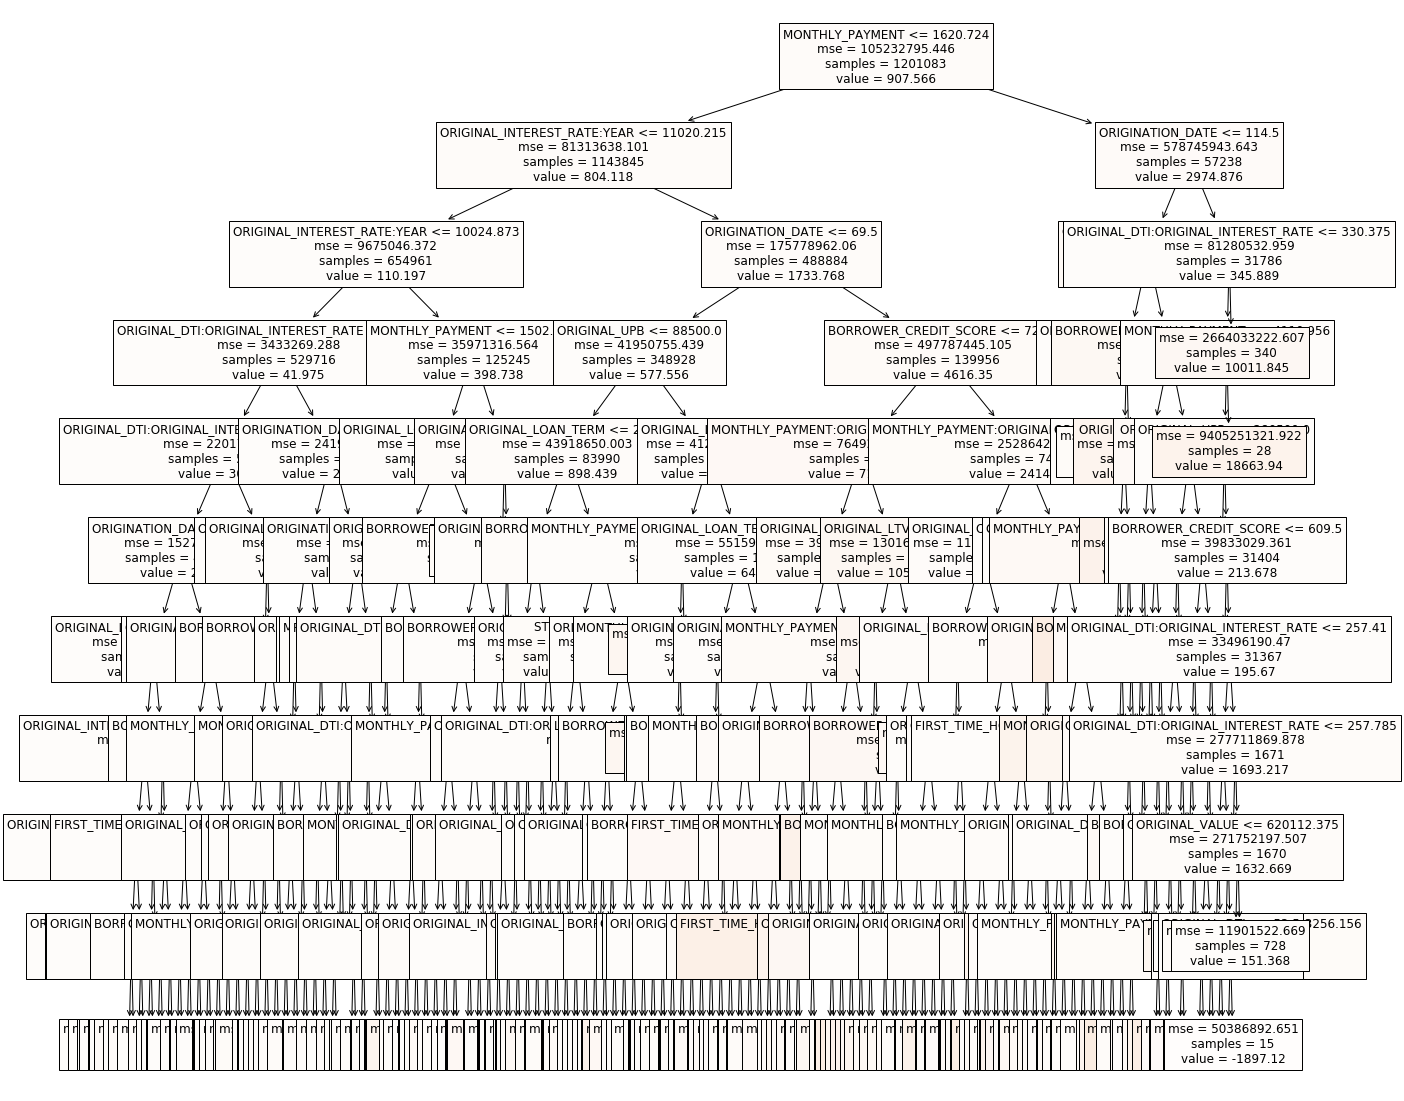

In [49]:
#Plot Decision Tree
plt.figure(figsize=(20,20))
plot_tree(dt_model, feature_names=X_tree_train.columns, filled=True, fontsize=12)
plt.show()

In [50]:
#Show Feature Importance
pd.DataFrame({'Importance': dt_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
ORIGINATION_DATE,2.910384e-01
STATE,1.769949e-01
BORROWER_CREDIT_SCORE,1.522628e-01
ORIGINAL_INTEREST_RATE:YEAR,9.959465e-02
ORIGINAL_LTV,9.394706e-02
MONTHLY_PAYMENT:ORIGINAL_DTI,8.709015e-02
MONTHLY_PAYMENT,3.834038e-02
ORIGINAL_DTI:ORIGINAL_INTEREST_RATE,1.711661e-02
LOAN_PURPOSE(T.P),1.560734e-02
ORIGINAL_LOAN_TERM,1.303691e-02


In [51]:
#Predict on validation set
dt_pred = dt_model.predict(X_tree_validation)

In [52]:
#Model performance
accuracy(df_validation['NET_LOSS'], dt_pred)

RMSE,Naive - RMSE
9675.4,291.001


# 11. Train Boosted Trees (XGBoost)

In [53]:
%%time
xgb_model = XGBRegressor(max_depth=10,
                         n_estimators = 50,
                         learning_rate=.2,
                         random_state=201,
                         n_jobs=num_cpus)
xgb_model.fit(X_tree_train, y_tree_train)

[14:17:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 1min 10s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=8, nthread=None, objective='reg:linear', random_state=201,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [54]:
#Show Feature Importance
pd.DataFrame({'Importance': xgb_model.feature_importances_}, index=X_tree_train.columns).sort_values(['Importance'], ascending=False)

,Importance
STATE,0.060619
MONTHLY_PAYMENT:ORIGINAL_DTI,0.058925
ORIGINATION_DATE,0.055420
FIRST_TIME_HOME_BUYER(N),0.053446
MONTHLY_PAYMENT,0.047525
ORIGINAL_UPB,0.047014
ORIGINAL_INTEREST_RATE:YEAR,0.045595
LOAN_PURPOSE(T.R),0.045575
LOAN_PURPOSE(T.P),0.043100
FIRST_TIME_HOME_BUYER(N):ORIGINATION_CHANNEL(T.OTHER),0.040870


In [55]:
#Predict on Validation Set
xgb_pred = xgb_model.predict(X_tree_validation)

In [56]:
#Model Performance
accuracy(df_validation['NET_LOSS'], xgb_pred)

RMSE,Naive - RMSE
9553.84,412.562


# 12. Predict on the Test Set

This section redos everything on the full training set in order to make predictions on the test set (e.g. replacing `df_smaller_train` with `df_train` and `df_validation` with `df_test`)

In [57]:
#Refit the Imputers and impute on df_train and df_test
imputer_mean_final = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer_zero_final = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
categorical_imputer_final = CategoricalImputer(other_threshold=.01)

In [58]:
imputer_mean_final.fit(df_train[continuous_mean])
df_train[continuous_mean] = imputer_mean_final.transform(df_train[continuous_mean])
df_test[continuous_mean] = imputer_mean_final.transform(df_test[continuous_mean])

In [59]:
imputer_zero_final.fit(df_train[continuous_zero])
df_train[continuous_zero] = imputer_zero_final.transform(df_train[continuous_zero])
df_test[continuous_zero] = imputer_zero_final.transform(df_test[continuous_zero])

In [60]:
categorical_imputer_final.fit(df_train[categorical_variables])
df_train[categorical_variables] = categorical_imputer_final.transform(df_train[categorical_variables])
df_test[categorical_variables] = categorical_imputer_final.transform(df_test[categorical_variables])

In [61]:
#Recreate the linear regression data necessary to train and predict using the same regression formula "formula_linear".
y_linear_train_final, X_linear_train_final = dmatrices(formula_linear, df_train, return_type="dataframe")

In [ ]:
linear_scaler_final = StandardScaler().fit(X_linear_train_final)
X_linear_train_final[:] = linear_scaler_final.transform(X_linear_train_final)

In [ ]:
#Build the X_test matrix to make final predictions from regression models
X_test = build_design_matrices([X_linear_train_final.design_info], df_test, return_type="dataframe")[0]
X_test[:] = linear_scaler_final.transform(X_test)

In [ ]:
#Retrain LASSO on new dataset
%%time
lasso_model_final = Lasso(alpha = .01, max_iter=1000000)
lasso_model_final.fit(X_linear_train_final, y_linear_train_final)

In [ ]:
#Final Prediction
lasso_pred_final = lasso_model_final.predict(X_test)

In [ ]:
#Recreate the tree based model data necessary to train and predict
X_tree_train_final = df_train[continuous_features_trees + cat_ordinal_features_trees]
y_tree_train_final = df_train['NET_LOSS']

In [ ]:
#Recreates the dummy variables and interactions
X_tree_train_patsy_final = dmatrix(formula_tree, df_train, return_type="dataframe")
#concatenates into same dataset
X_tree_train_final = pd.concat([X_tree_train_final, X_tree_train_patsy_final], axis=1)

In [ ]:
#Ordinal encodes variables
ordinal_encoder_final = OrdinalEncoder()
ordinal_encoder_final.fit(X_tree_train_final[cat_ordinal_features_trees])
X_tree_train_final[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_train_final[cat_ordinal_features_trees])

In [ ]:
#Replace [ ] with parentheses. XGBoost does not like [ ] 
X_tree_train_final.columns = X_tree_train_final.columns.str.replace('[', '(').str.replace(']', ')')

In [ ]:
#Recreate tree based model data on the test set to predict
X_tree_test = df_test[continuous_features_trees + cat_ordinal_features_trees]
y_tree_test = df_test['NET_LOSS']

X_tree_test_patsy = build_design_matrices([X_tree_train_patsy_final.design_info], df_test, return_type="dataframe")[0]

X_tree_test = pd.concat([X_tree_test, X_tree_test_patsy], axis=1)

X_tree_test[cat_ordinal_features_trees] = ordinal_encoder_final.transform(X_tree_test[cat_ordinal_features_trees])

X_tree_test.columns = X_tree_test.columns.str.replace('[', '(').str.replace(']', ')')

In [ ]:
#Retrain Decision Tree to make final predictions
%%time
dt_model_final = DecisionTreeRegressor(max_depth=10,
                                       min_samples_split=1000,
                                       max_features=.5,
                                       min_impurity_decrease=.1,
                                       random_state=201)
dt_model_final.fit(X_tree_train_final, y_tree_train_final)
dt_pred_final = dt_model_final.predict(X_tree_test)

In [ ]:
#Retrain XGBoost to make final predictions
%%time
xgb_model_final = XGBRegressor(max_depth=8,
                               n_estimators = 100,
                               learning_rate=.1,
                               random_state=201,
                               n_jobs=num_cpus)
xgb_model_final.fit(X_tree_train_final, y_tree_train_final)
xgb_pred_final = xgb_model_final.predict(X_tree_test)

In [ ]:
#Validation Set Performance
accuracy(df_test['NET_LOSS'], lasso_pred_final)
accuracy(df_test['NET_LOSS'], xgb_pred_final)
accuracy(df_test['NET_LOSS'], dt_pred_final)

In [ ]:
y_valid = df_test['NET_LOSS']

In [ ]:
#Lasso Predictions vs Actual
plt.figure(figsize=(6,6))
plt.scatter(xgb_pred_final, y_valid, s = 0.2)
plt.xlim(0, 20000)
plt.ylim(0,150000)
plt.plot([0, 150000], [0, 150000], color='r', linestyle='-', linewidth=2)
plt.suptitle('Predicted vs Actual', fontsize=20)
plt.xlabel('lasso_pred', fontsize=18)
plt.ylabel('y_valid', fontsize=18)
plt.show()

In [ ]:
final_pred_1 = dt_pred_final
final_pred_2 = xgb_pred_final
final_pred_3 = lasso_pred_final

# 13. Write Predictions to csv

In [ ]:
#Load a fresh copy of the test data
%%time
#df_test_fresh = pd.read_csv('../Shared Data (Read Only)/Fannie Mae Data/FannieMaeNetLossSmallTest.csv', sep='|') ##Use this one for the smaller training data
df_test_fresh = pd.read_csv('/FannieMaeNetLossTest.csv', sep='|')
df_test_fresh['PREDICTIONS'] = final_pred_2

In [ ]:
#Write out to csv the fresh copy with predictions
df_test_fresh.to_csv('FannieMaeNetLossTestWithPredictions2.csv', sep='|', index=False)
